Falstad schematics:

- [regular oscillation](https://falstad.com/circuit/circuitjs.html?ctz=CQAgjCAMB0l3BWEBOWkwHYwGYeIExgAcE+GISALNhQKYC0YYAUAE7gYBsIRkI2RSjz58wkZgHcO3XtP4J8UZgGN+g+YszdsCqFDRwwlZCdNnzIejEoIiCSAjD58RIoSLkEzADZqhsgSEdRRFoCBg4DyJOTlxkTkhOLmIlAHM5YIz1EWZCPkCNEGpFTNFIfEpxAHs9MG4+SpMKfXCQev4QEM6Omnz+ZgFugDFWiPh0fXgxCEYQAGEAQwAHBeUASwAXBYA7ZVoBog6RvQiIMFgZiABJbYATAFdlLd39wb5j0XAJ2YAlWgBnNb-Z57ZhAA)

- [oscillation with a shock](https://falstad.com/circuit/circuitjs.html?ctz=CQAgjCAMB0l3BWEBOWkwHYwGYeIExgAcEALPiEqdpQKYC0YYAUAE4j76kcIBsHXcPiJQUkZgGMQ2It3x8BchZCho4YUsi3adukPRhwiCbLwynkvUhuQJblZgBtpsoSJlL+KmBANrCZqR2vAhEGBgBNOLsnNxgwi5xCSpg4gBuIEQq8vxZ4Lwq3EiplKLe0CyYImAFPPw1KbX1qvDqZWgQqa3lkBT4PWDFDMhQzADubnWZ2crj0-kpCQ2jExpJ1aRxteKrm5OxkzsLUwc5owAOilMekxDezADmV2enRCL3hCo3Z6RWUym9UjiAD24BA3EKkC0pR8omaNARHFEFBoTFGMjBADE7i1Wnc1KlfBAAMIAQ3OpIkAEsAC6kgB2ElozAxFGx7XQ4FgRJAAEl6QATACuEjpjOZGJU7JS4E5jBAACVaABnKnKsVM5hAA)


In [1]:
# Import Falstad results
dfs = {
#    'cap': 'falstad-data/100mH_200_15uF-capacitor.txt.csv',
#    'res': 'falstad-data/100mH_200_15uF-resistor.txt.csv',
    'cap': 'falstad-data/100mH_10_15uF-capacitor.txt.csv',
#    'cap': 'falstad-data/100mH_10-100_15uF-capacitor.txt.csv',
    }

import pandas as pd
joined = pd.DataFrame()
for key, fn in dfs.items():
    dfs[key] = pd.read_csv(fn, index_col='time')
    joined = joined.join(dfs[key].rename(columns={'voltage': 'V'+key}), how='right')

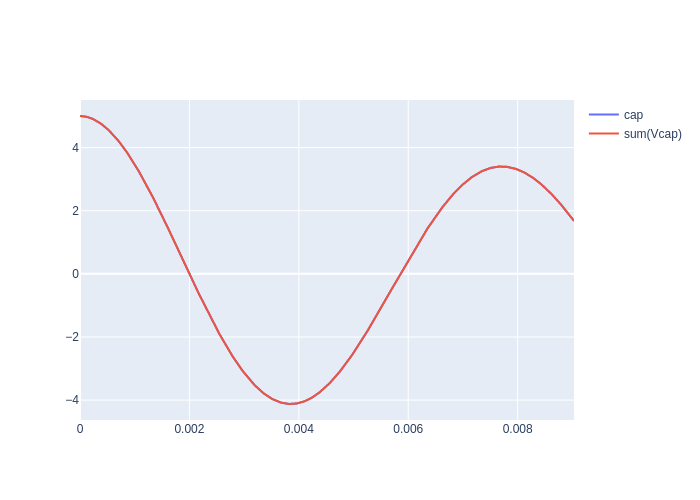

In [2]:
# Simple visualization
import plotly.graph_objects as go
fig = go.Figure()
for key, df in dfs.items():
    fig.add_scatter(x=df.index, y=df['voltage'], name=key)

fig.add_scatter(x=joined.index, y=sum(joined[key] for key in joined.columns),
        name='sum(%s)'%', '.join(joined.columns))

fig.show()


Approximating 19 samples, from 0.0 to 0.009, step 0.0005


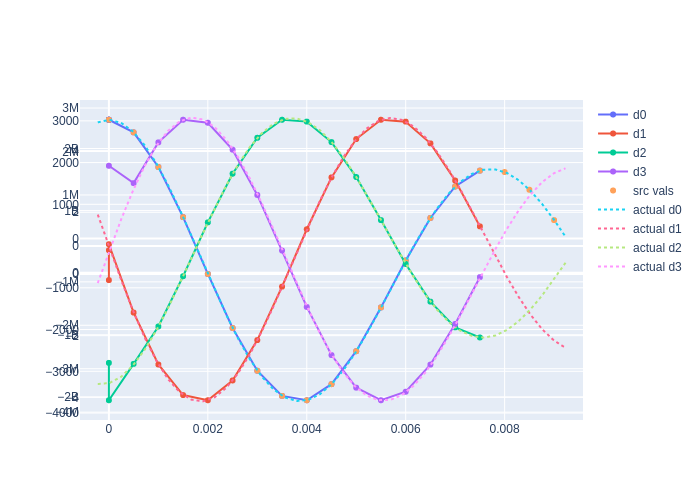

In [3]:
# Use experimental polynomial approximator module
import euler_approx

# Derivative approximator with history limit
approx = euler_approx.deriv_approx()
approx.reset_derivs(num_derivs=4, max_history=1)

# Intentionally reduce the sample rate
trange = joined.index[::100]
src_vals = joined['Vcap']
print(f'Approximating {len(trange)} samples, '
        f'from {trange[0]} to {trange[-1]}, step {(trange[-1] - trange[0]) / (len(trange) - 1):.3}')
derivs = [[] for _ in range(4)]
for t in trange:
    volt = src_vals[t]
    approx.approximate(volt, t)
    t, deriv_set = next(approx.reversed_iter_derivs())
    for i, (deriv, next_val) in enumerate(zip(derivs, deriv_set)):
        deriv.append((t, next_val))

import plotly.graph_objects as go
fig = go.Figure()
for i, deriv in enumerate(derivs):
    if i:
        fig.update_layout({'yaxis%d'%(i+1): dict(overlaying='y')})
    x_y = list(zip(*list(deriv)))
    fig.add_scatter(x=x_y[0], y=x_y[1], name='d%d'%i, yaxis='y%d'%(i+1))
fig.add_scatter(x=trange, y=src_vals[trange], mode='markers', name='src vals')

#
# Compare to actual derivatives
#
import cmath
ACT_SAMPLES = 40
def calc_euler_deriv(omega, phi, t, lvl):
    """Calculate Euler's function derivative"""
    return omega ** lvl * cmath.exp(omega*t + phi)
def draw_actual_euler(fig, params, scale, zero_shift, nderivs, tmin, tmax, samples=ACT_SAMPLES):
    """Draw actual Euler's function"""
    # Extend the t-range
    tmin -= (tmax - tmin) / ACT_SAMPLES
    tmax += (tmax - tmin) / ACT_SAMPLES
    for i in range(nderivs):
        trange=[t * (tmax - tmin) / samples + tmin for t in range(0, samples + 1)]
        deriv = [calc_euler_deriv(*params, t=t, lvl=i) * scale
                    + (0 if i else zero_shift)
                for t in trange]
        fig.add_scatter(x=trange, y=[v.real for v in deriv],
                mode='lines', line_dash='dot', name='actual d%d'%i, yaxis='y%d'%(i+1) if i else 'y')

# Actual derivatives from precalculated parameters
# R 10Ohm, L 100mH, C 15uF
omega = -50+814.9642118931769j
phase = -9.496143919989107-0.061275581577500224j
capacitance = 15e-6
draw_actual_euler(fig, (omega, phase), 1/capacitance, 0, 4, trange[0], trange[-1])

# Actual derivatives from precalculated parameters
# R 100Ohm, L 100mH, C 15uF
omega2 = -500+645.4972243679028j
phase2 = -4.526018551272416-4.745587636838345j
tmin = .009
#draw_actual_euler(fig, (omega2, phase2), 1/capacitance, 0, 4, tmin, trange[-1])

fig.show()


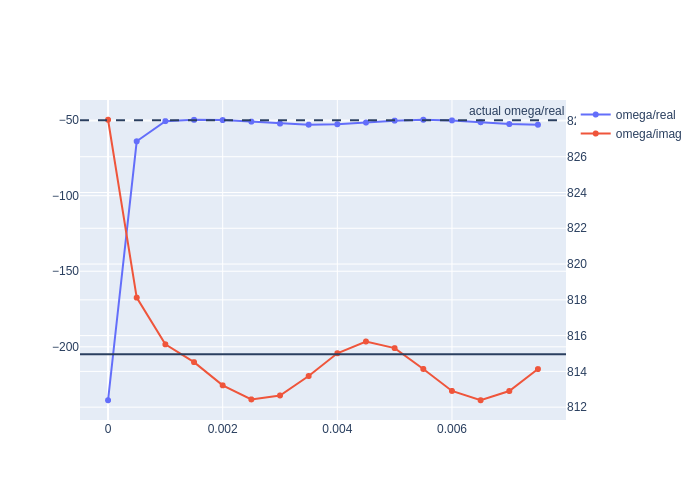

In [4]:
# Exponent component reversal

# Join derivative values in a DataFrame
df_ders = pd.DataFrame()
for i, der in enumerate(derivs):
    der = pd.DataFrame(der, columns=['time', 'deriv%d'%i])
    der.set_index('time', inplace=True)
    der = der[~der.index.duplicated(keep='last')]
    df_ders = df_ders.join(der, how='right')

omega_line = [[], []]
for t, *derivs in df_ders.itertuples():
    omega_line[0].append(t)
    # Keep the first result only
    omega_line[1].append(euler_approx.calc_omegas_from_4derivs(derivs)[0])

fig = go.Figure(layout={'yaxis2': dict(overlaying='y', side='right')})
fig.add_scatter(x=omega_line[0], y=[v.real for v in omega_line[1]], name='omega/real', yaxis='y')
fig.add_scatter(x=omega_line[0], y=[v.imag for v in omega_line[1]], name='omega/imag', yaxis='y2')
fig.add_hline(omega.real, line_dash='dash', annotation_text='actual omega/real')
#Bug workaround: The add_hline(yref='y2') does not work, use add_shape() instead
fig.add_shape(x0=0, y0=omega.imag, x1=1, y1=omega.imag, line_dash='dash', name='actual omega/imag',
        xref='paper', yref='y2')
fig.show()
